# epitopepredict basics

__epitopepredict__ provides a standardized programmatic interface for executing several epitope/MHC binding prediction methods. The results from each method can then be processed and visualized in a consistent manner. 
The Tepitope module implements the TEPITOPEPan method and requires no external program to run. 
netMHCIIpan must be downloaded separately from the website and installed on your system. 

### References:

* D. Farrell and S. V Gordon, “Epitopemap: a web application for integrated whole proteome epitope prediction,” BMC Bioinformatics, vol. 16, no. 1, p. 221, 2015.

* Farrell, D. et al., 2016. Integrated computational prediction and experimental validation identifies promiscuous T cell epitopes in the proteome of Mycobacterium bovis. Microbial Genomics, (July). 

* L. Zhang, Y. Chen, H.-S. Wong, S. Zhou, H. Mamitsuka, and S. Zhu, “TEPITOPEpan: extending TEPITOPE for peptide binding prediction covering over 700 HLA-DR molecules.,” PLoS One, vol. 7, no. 2, p. e30483, Jan. 2012.

* A. S. De Groot and W. Martin, “Reducing risk, improving outcomes: bioengineering less immunogenic protein therapeutics.,” Clin. Immunol., vol. 131, no. 2, pp. 189–201, May 2009.

* F. a Chaves, A. H. Lee, J. L. Nayak, K. a Richards, and A. J. Sant, “The utility and limitations of current Web-available algorithms to predict peptides recognized by CD4 T cells in response to pathogen infection.,” J. Immunol., vol. 188, no. 9, pp. 4235–48, May 2012.

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
pd.set_option('max_colwidth', 80)
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
from IPython.display import display, HTML

import epitopepredict as ep
from epitopepredict import base, sequtils, analysis

## Load sequences from fasta or genbank file
We can load fasta or genbank format. This example contains sequences from zaire ebola virus.

In [2]:
genbankfile = '../testing/zaire-ebolavirus.gb'
fastafile = '../testing/zaire-ebolavirus.faa'

#get data in fasta format
zaire = sequtils.fasta_to_dataframe(fastafile)
#get data in genbank format into a dataframe
zaire = sequtils.genbank_to_dataframe(genbankfile, cds=True)

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [3]:
#get list of predictors
print ep.predictors

['tepitope', 'netmhciipan', 'iedbmhc1', 'iedbmhc2', 'mhcflurry', 'bcell']


In [4]:
savepath = 'test_iedbmhc1'
#create a predictor
Pi = ep.get_predictor('iedbmhc1')

#run prediction for several alleles and save results to savepath
alleles = ep.mhc1_supertypes
Pi.predictProteins(zaire,length=11,alleles=alleles,path=savepath,overwrite=False)
#note that if we provided a path data is written to disk and not kept in the object by default
#we can reload
Pi.load(path=savepath)
Pi.summarize()
Pi.allele_summary()
Pi.protein_summary()

predictions done for 9 proteins in 6 alleles
results saved to /home/farrell/gitprojects/epitopepredict/examples/test_iedbmhc1
summary: 32418 peptides in 9 proteins and 6 alleles
            peptide
name               
ZEBOVgp1       4374
ZEBOVgp2       1980
ZEBOVgp3       1896
ZEBOVgp4       3996
ZEBOVgp4.1     2124
ZEBOVgp4.2     1722
ZEBOVgp5       1668
ZEBOVgp6       1446
ZEBOVgp7      13212


## Results are kept in pandas dataframes

The `predictProteins` and `predict` methods return a pandas DataFrame. Here name is the protein identifier from the input file (a locus tag for example) and a score column which will differ between methods. Methods can be run for varying peptide lengths, with the core usually being the highest scoring in that peptide/n-mer (but not always). MHC-I methods may have a 'core' field for convenience but it is the same as the peptide.

In [5]:
b = Pi.getBinders(cutoff=5)
print 'results format:'
print b[:10]

results format:
     pos       allele  length      peptide  percentile_rank               method  ann_ic50  \
209  209  HLA-A*01:01      11  SSGYYSTTIRY             3.85  Consensus (ANN,SMM)     132.0   
221  221  HLA-A*01:01      11  ATGFGTNETEY             1.30  Consensus (ANN,SMM)     265.0   
416  416  HLA-A*01:01      11  ASDTPSATTAA             6.35  Consensus (ANN,SMM)    1580.0   
564  564  HLA-A*01:01      11  TTQALQLFLRA             7.90  Consensus (ANN,SMM)    2210.0   
160  160  HLA-A*01:01      11  LYDRLASTVIY             2.20  Consensus (ANN,SMM)    2212.0   
203  203  HLA-A*01:01      11  NATEDPSSGYY             3.95  Consensus (ANN,SMM)    3928.0   
523  523  HLA-A*01:01      11  GAAIGLAWIPY            12.15  Consensus (ANN,SMM)    4981.0   
439  439  HLA-A*01:01      11  STDFLDPATTT             3.95  Consensus (ANN,SMM)    6276.0   
279  279  HLA-A*01:01      11  EIDTTIGEWAF            16.95  Consensus (ANN,SMM)    7732.0   
442  442  HLA-A*01:01      11  FLDPATTTSPQ  

## Filter/rank results

There are several possible ways to select lists of top epitope candidates from such binding predictions. Two such methods are the **rank and promiscuity approaches**. For promiscuity you can choose a global percentile cut-off and minimum number of alleles. Note that these two methods will produce similar but not identical results.


promiscuous binders:
        peptide  pos      name  alleles     score      mean  median_rank         core
67  STTAAIMLASY  109  ZEBOVgp3        3  0.462639  0.256172         10.0  STTAAIMLASY
78  VQLPQYFTFDL  165  ZEBOVgp3        3  0.399407  0.272236         11.0  VQLPQYFTFDL
30  KQIPIWLPLGV   89  ZEBOVgp3        2  0.590489  0.353906          4.0  KQIPIWLPLGV
12  FTFDLTALKLI  171  ZEBOVgp3        2  0.540673  0.335990          4.5  FTFDLTALKLI
25  IQAIMTSLQDF  236  ZEBOVgp3        2  0.437021  0.275874          5.5  IQAIMTSLQDF
40  LTALKLITQPL  175  ZEBOVgp3        2  0.347845  0.238972          6.5  LTALKLITQPL
0   AFILEAMVNVI   71  ZEBOVgp3        2  0.374859  0.227457          9.0  AFILEAMVNVI
62  RLGPGIPDHPL  136  ZEBOVgp3        2  0.506244  0.406920         10.0  RLGPGIPDHPL
63  RLLRIGNQAFL  147  ZEBOVgp3        2  0.442624  0.327792         10.5  RLLRIGNQAFL
36  LMKQIPIWLPL   87  ZEBOVgp3        2  0.405150  0.305760         13.0  LMKQIPIWLPL
31  KTYSFDSTTAA  103  ZEBOVgp3   

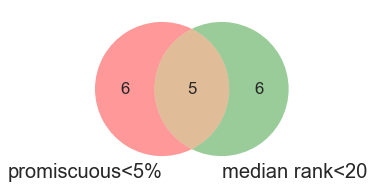

In [6]:
#get promiscuous binders in at least 2 alleles above 5 percentile cutoff
name='ZEBOVgp3'
pb = Pi.promiscuousBinders(name=name,n=2,cutoff=5)
print 'promiscuous binders:'
print pb
print
#binders sorted by median rank over all alleles, cutoff here is the median rank
print 'median ranked binders:'
mb = Pi.rankedBinders(name=name,cutoff=40)
print mb

ax=ep.utilities.venndiagram([pb.peptide, mb.peptide],
                      ['promiscuous<5%','median rank<20'])

## Plotting results
Plots are primarily needed to show predicted binders over protein sequences. Since sequences are usually several hundred amino acids in length and multiple alleles various different ways of summerizing the results are used. Three formats are available: 1. as a heatmap, 2. bar plot or 3. as tracks showing overlapping binders per allele.

/home/farrell/gitprojects/epitopepredict/epitopepredict/plotting.py:411: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = P.data[P.data.name==name].sort('pos')


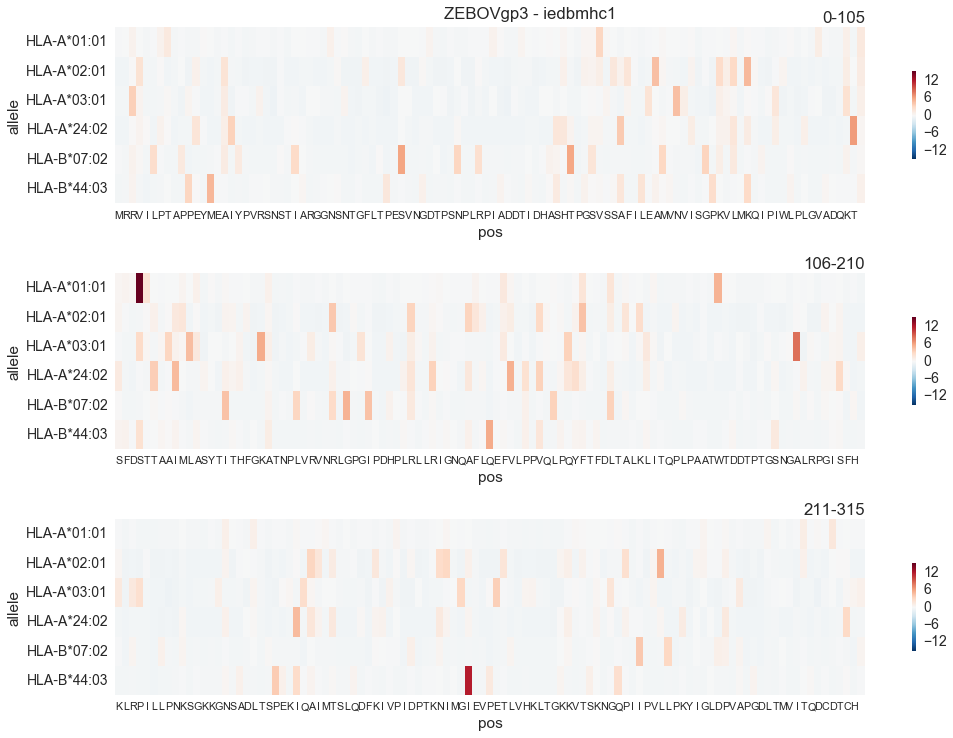

In [7]:
reload(ep.plotting)
ax = ep.plotting.plot_binder_map(Pi, name, 'score', chunks=3)

/home/farrell/gitprojects/epitopepredict/epitopepredict/plotting.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[key][X[key]<cutoff] = np.nan


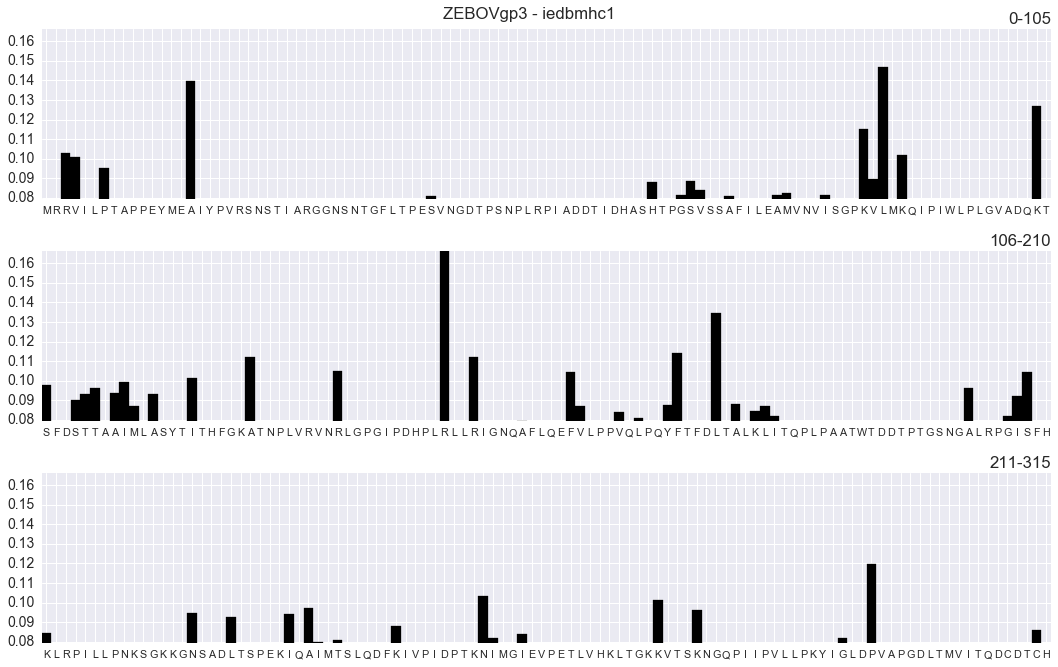

In [8]:
ax = ep.plotting.plot_bars(Pi, name, cutoff=20, chunks=3) 

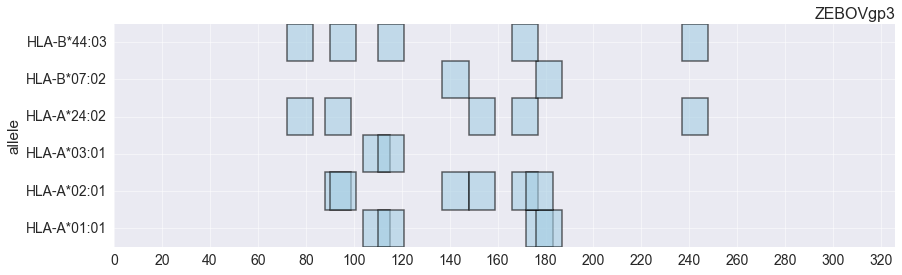

In [9]:
ax = ep.plotting.plot_tracks([Pi], name, cutoff=5, n=2, figsize=(14,4))

## Result summaries
Results may be summarised as heatmaps or tables breaking down the results for each binder per allele. Looking at results in an individual protein is usually the most useful.

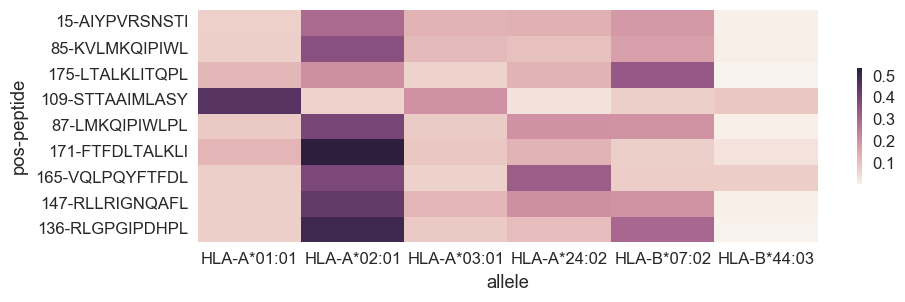

In [10]:
reload(base)
mbi = Pi.rankedBinders(cutoff=20)
pbi = Pi.promiscuousBinders(n=2,cutoff=5)
#summary for a single protein
x = base.reshape_data(Pi, pbi.peptide, name=name)
ax = base.plot_summary_heatmap(x)

In [11]:
t = ep.protein_summary(Pi, pbi.peptide, name=name)
print 'formatted as a table:'
display(t)

formatted as a table:


## get n-mer peptides from predicted binder sequences
This is uses the host protein sequences to derive nmers for preparing peptides for assays.

In [12]:
x = analysis.get_nmer(pbi, zaire)
x = pd.DataFrame(x, columns=['peptide'])
x = x.rename(columns={'peptide':'20mer'})
x = pbi.merge(x,left_index=True,right_index=True).reset_index(drop=True)

print x[:5]

       peptide  pos        name  alleles     score      mean  median_rank         core  \
0  AAIGLAWIPYF  524    ZEBOVgp4        2  0.247161  0.237650         20.0  AAIGLAWIPYF   
1  AAMDWYQASVF  207    ZEBOVgp7        3  0.359280  0.277068         45.0  AAMDWYQASVF   
2  AFHKEGAFFLY  151  ZEBOVgp4.2        2  0.209669  0.207292         14.0  AFHKEGAFFLY   
3  AIYPVRSNSTI   15    ZEBOVgp3        2  0.305055  0.248629         20.0  AIYPVRSNSTI   
4  ALAVPQVLGGL  901    ZEBOVgp7        2  0.292990  0.231541        103.0  ALAVPQVLGGL   

                  20mer  
0  KSAMNRMKPGPAKFSLLHES  
1  RDRFKRTSFFLWVIILFQRT  
2  IYRGTTFAEGVVAFLILPQA  
3  NPNSTIESPLWALRVILAAG  
4  GKDSNSLDIIHAEFQASLAE  


## peptide properties
We can make a rough estimate of the chemical properties of a set of peptides. This may assist in determining which peptides to synthesize/assay out of set of predicted sequences.

In [13]:
#x is the dataframe created above
x = analysis.peptide_properties(x, colname='20mer')
print x[['20mer','hydro','net_charge']]
#ax=x.hist(['hydro','net_charge'],figsize=(6,2))

                   20mer  hydro  net_charge
0   KSAMNRMKPGPAKFSLLHES   0.35           3
1   RDRFKRTSFFLWVIILFQRT   0.50           4
2   IYRGTTFAEGVVAFLILPQA   0.60           0
3   NPNSTIESPLWALRVILAAG   0.60           0
4   GKDSNSLDIIHAEFQASLAE   0.40          -3
5   DNLTYVQLESRFTPQFLLQL   0.45          -1
6   TRNSQTQTDPICNHSFEEVV   0.25          -2
7   ITAAFHTFFSVRILQYHHLG   0.50           1
8   TIIITRTNMGFLVELQEPDK   0.40          -1
9   KNLTRKIRSEELSFTVVSNG   0.30           2
10  TFVKEWIINRGTIVPLWIVY   0.60           1
11  QLCELFSIQKHWGHPVLHSE   0.40          -1
12  ALRPIVIFETYCVFKYSIAK   0.55           2
13  VVLKVFLSDTEGMLWLNDNL   0.50          -2
14  LGYGDYVFWKIPISMLPLNT   0.50           0
15  NQFPPLPMIKELLWEFYHLD   0.55          -2
16  KLVNDYLKFFLIVQALKHNG   0.50           2
17  LWLNDNLAPFFATGYLIKPI   0.65           0
18  ARLFLRTSISSFLTFVKEWI   0.55           2


## Compare predictors
We can compare the results for two predictors.

predictions done for 9 proteins in 6 alleles
results saved to /home/farrell/gitprojects/epitopepredict/examples/test_mhcflurry


Using Theano backend.


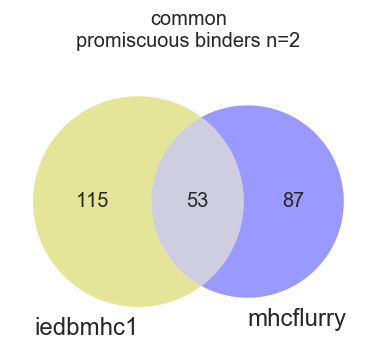

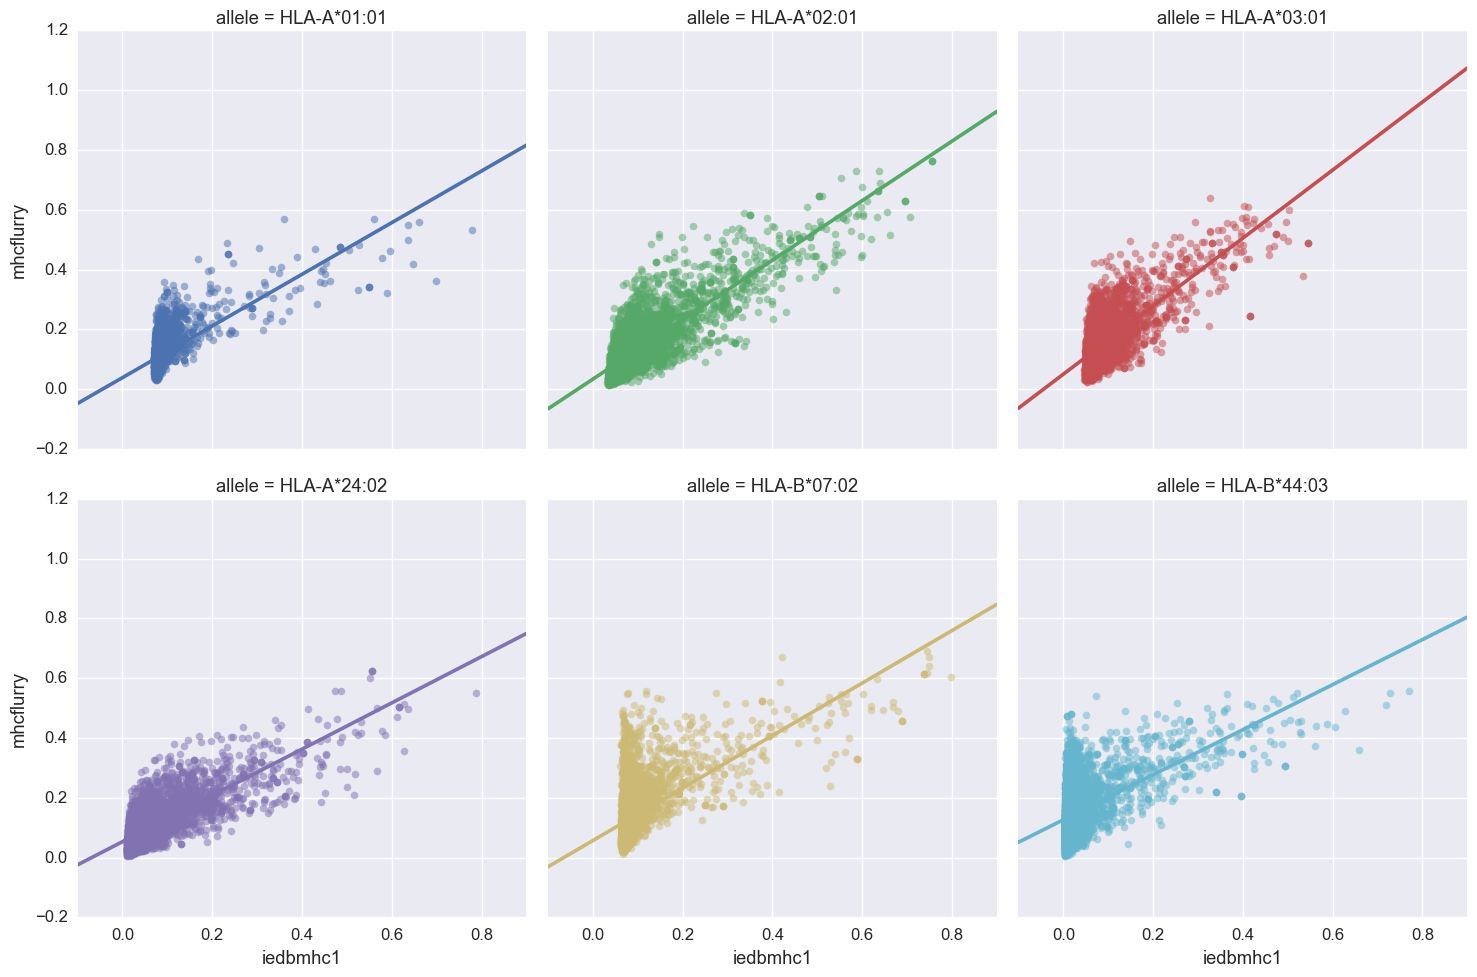

In [15]:
#create another mhcflurry predictor and compare it to the iedb mhc1 results
reload(ep)
Pf = ep.get_predictor('mhcflurry')
savepath1='test_mhcflurry'
Pf.predictProteins(zaire,length=11,alleles=alleles,path=savepath1,overwrite=False)
Pf.load(path=savepath1)
ep.compare_predictors(Pi, Pf, cutoff=5)